<a href="https://colab.research.google.com/github/aaptecode/DS-Unit-4-Sprint-4-Deep-Learning/blob/master/LS_DS_Unit_4_Sprint_Challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Unit 4 Sprint Challenge 4

## RNNs, CNNs, AutoML, and more...

In this sprint challenge, you'll explore some of the cutting edge of Data Science.

*Caution* - these approaches can be pretty heavy computationally. All problems were designed so that you should be able to achieve results within at most 5-10 minutes of runtime on Colab or a comparable environment. If something is running longer, doublecheck your approach!

In [0]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
style.use('seaborn-whitegrid')

## Part 1 - RNNs

Use an RNN to fit a simple classification model on tweets to distinguish from tweets from Austen Allred and tweets from Weird Al Yankovic.

Following is code to scrape the needed data (no API auth needed, uses [twitterscraper](https://github.com/taspinar/twitterscraper)):

In [30]:
!pip install twitterscraper

  Stored in directory: /root/.cache/pip/wheels/45/50/9b/70128bca07e2bf8b5ed3f504002e9e74a6eaa5e756341b6931
Successfully built twitterscraper


In [31]:
from twitterscraper import query_tweets

austen_tweets = query_tweets('from:austen', 1000)
len(austen_tweets)

INFO: queries: ['from:austen since:2006-03-21 until:2006-11-14', 'from:austen since:2006-11-14 until:2007-07-11', 'from:austen since:2007-07-11 until:2008-03-05', 'from:austen since:2008-03-05 until:2008-10-30', 'from:austen since:2008-10-30 until:2009-06-25', 'from:austen since:2009-06-25 until:2010-02-19', 'from:austen since:2010-02-19 until:2010-10-15', 'from:austen since:2010-10-15 until:2011-06-11', 'from:austen since:2011-06-11 until:2012-02-04', 'from:austen since:2012-02-04 until:2012-09-30', 'from:austen since:2012-09-30 until:2013-05-26', 'from:austen since:2013-05-26 until:2014-01-20', 'from:austen since:2014-01-20 until:2014-09-15', 'from:austen since:2014-09-15 until:2015-05-12', 'from:austen since:2015-05-12 until:2016-01-05', 'from:austen since:2016-01-05 until:2016-08-31', 'from:austen since:2016-08-31 until:2017-04-26', 'from:austen since:2017-04-26 until:2017-12-21', 'from:austen since:2017-12-21 until:2018-08-16', 'from:austen since:2018-08-16 until:2019-04-12']
INFO

181

In [63]:
austen_tweets[180].text.split(" ")

['Thanks', 'for', 'being', 'a', 'part', 'of', 'it!']

In [33]:
al_tweets = query_tweets('from:AlYankovic', 1000)
len(al_tweets)

INFO: queries: ['from:AlYankovic since:2006-03-21 until:2006-11-14', 'from:AlYankovic since:2006-11-14 until:2007-07-11', 'from:AlYankovic since:2007-07-11 until:2008-03-05', 'from:AlYankovic since:2008-03-05 until:2008-10-30', 'from:AlYankovic since:2008-10-30 until:2009-06-25', 'from:AlYankovic since:2009-06-25 until:2010-02-19', 'from:AlYankovic since:2010-02-19 until:2010-10-15', 'from:AlYankovic since:2010-10-15 until:2011-06-11', 'from:AlYankovic since:2011-06-11 until:2012-02-04', 'from:AlYankovic since:2012-02-04 until:2012-09-30', 'from:AlYankovic since:2012-09-30 until:2013-05-26', 'from:AlYankovic since:2013-05-26 until:2014-01-20', 'from:AlYankovic since:2014-01-20 until:2014-09-15', 'from:AlYankovic since:2014-09-15 until:2015-05-12', 'from:AlYankovic since:2015-05-12 until:2016-01-05', 'from:AlYankovic since:2016-01-05 until:2016-08-31', 'from:AlYankovic since:2016-08-31 until:2017-04-26', 'from:AlYankovic since:2017-04-26 until:2017-12-21', 'from:AlYankovic since:2017-12

960

In [53]:
al_tweets[959].text

'Excited to already see ads for the next Tom Cruise action movie!pic.twitter.com/xyqdaBlMHT'

In [54]:
len(austen_tweets + al_tweets)

1141

Your tasks:

- Encode the characters to a sequence of integers for the model
- Get the data into the appropriate shape/format, including labels and a train/test split
- Use Keras to fit a predictive model, classifying tweets as being from Austen versus Weird Al
- Report your overall score and accuracy

For reference, the [Keras IMDB sentiment classification example](https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py) will be useful, as well the RNN code we used in class.

*Note* - focus on getting a running model, not on maxing accuracy with extreme data size or epoch numbers. Only revisit and push accuracy if you get everything else done!

In [96]:
austen_text = ''

for tweet in austen_tweets:
    try:
#         article.download()
#         article.parse()
        austen_text += '\n\n' + tweet.text
    except:
        print('Failed: ' + tweet.url)
  
austen_text = austen_text.split('\n\n')[1:]
# austen_text = austen_text.split(' ')
print(austen_text)

['I love love love working with great people.pic.twitter.com/fCKOm6Vl', 'Elon Musk is severely underrated', 'SpaceX 2002 vs 2017pic.twitter.com/dtzBID2Q3v', 'Yes. On the blockchain.', 'This is a publicly traded company with no revenue and a $3 Billion+ market cap: http://www.longfincorp.com/business.html\xa0. Starting to get a sense for what 1999 was like. $LFIN', 'pic.twitter.com/t5K0TG86gs', 'Convo in the @LambdaSchool Slack right now:', '"I started two other bootcamps before Lambda School, then quit because I learned more in the precourse work at Lambda than 6 and 8 weeks there."', '"I have a CS degree and I learn more with Lambda than I did with that."', 'Startup roadmap 2017:', 'Find an industry insulated by regulation and/or being boring.', 'Enter industry with software.', 'Industry thinks you’re a punk kid that can’t possibly understand intricacies of x. They’re right at first, but you learn.', '10 yrs later no one can catch you.', "Hadn't set it up on a carrier before. Looks li

In [92]:
al_text = ''

for tweet in al_tweets:
    try:
#         article.download()
#         article.parse()
        al_text += '\n\n' + tweet.text
    except:
        print('Failed: ' + tweet.url)
  
al_text = al_text.split('\n\n')[1:]
print(al_text)

['RT @GeoffTheRobot: Hey Al, you played zydeco on my ribs at the RED premiere and it airs tonight on Late Late with @CraigyFerg!', "Wow, I can't believe how quickly they were able to rush this Mel Gibson biopic into theatres. http://twitpic.com/2xbnjh", "I promise you, I have NOT been uploading my twitpics sideways.  It's an enigma, I tell you!", "Okay, fine, Tom, stop groveling, I'll follow you on Twitter. http://twitpic.com/2x38u7", 'BORG 9!!! http://twitpic.com/2wwo9c', 'Hanging with a friend at the RED premiere... http://twitpic.com/2wvnbu', 'Another Sunday night, another arm-wrestling match with @Fred_Willard... http://twitpic.com/2wmrix', 'Happy 10/10/10 - the last binary calendar date until... well, tomorrow.', "Lookit! I'm doing commentary for The Simpsons Season 14 DVD! http://twitpic.com/2vhlo1", 'The Essential “Weird Al” Yankovic will be released in the UK on Oct. 18 – but hey, you can pre-order now! http://is.gd/fP2Aw', 'Good Lord... http://is.gd/fOguL', "Yes... The amazing

In [93]:
chars_austen = list(set(austen_text)) # split and remove duplicate characters. convert to list.
chars_al = list(set(al_text))

num_chars = len(chars_austen) # the number of unique characters
txt_data_size = len(austen_text)

print("unique characters : ", num_chars)
print("txt_data_size : ", txt_data_size)

unique characters :  223
txt_data_size :  226


In [94]:
# one hot encode
char_to_int = dict((c, i) for i, c in enumerate(chars)) # "enumerate" returns index and value. Convert it to dictionary
int_to_char = dict((i, c) for i, c in enumerate(chars))
print(char_to_int)
print("----------------------------------------------------")
print(int_to_char)
print("----------------------------------------------------")
# integer encode input data
integer_encoded = [char_to_int[i] for i in austen_text] # "integer_encoded" is a list which has a sequence converted from an original data to integers.
print(integer_encoded)
print("----------------------------------------------------")
print("data length : ", len(integer_encoded))

{'': 0, 'Just might!': 1, "It hadn't recovered by the time I sent that tweet... it started at $87 and finished the day at $68, so check your facts before you try to call someone out": 2, 'https://twitter.com/AustenAllred/status/981723910986190848\xa0…': 3, 'Try it out, see if it works!': 4, 'Sounds like @Opendoor': 5, 'This team will help build an engine for identifying and building incredible courses at breathtaking speed.': 6, 'You still pay a percentage of software income once it’s over $50k regardless of where it comes from': 7, 'Find an industry insulated by regulation and/or being boring.': 8, 'SpaceX 2002 vs 2017pic.twitter.com/dtzBID2Q3v': 9, 'If you have that graph at that scale you can draw it on a napkin and be funded.': 10, 'The lambda school ISA disappears after five years. If you don’t get a job you owe nothing.': 11, '"I started two other bootcamps before Lambda School, then quit because I learned more in the precourse work at Lambda than 6 and 8 weeks there."': 12, 'The

In [0]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Conclusion - RNN runs, and gives pretty decent improvement over a naive "It's Al!" model. To *really* improve the model, more playing with parameters, and just getting more data (particularly Austen tweets), would help. Also - RNN may well not be the best approach here, but it is at least a valid one.

## Part 2- CNNs

Time to play "find the frog!" Use Keras and ResNet50 to detect which of the following images contain frogs:

In [18]:
!pip install google_images_download

    100% |████████████████████████████████| 911kB 19.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/d2/23/84/3cec6d566b88bef64ad727a7e805f6544b8af4a8f121f9691c
Successfully built google-images-download


In [19]:
from google_images_download import google_images_download

response = google_images_download.googleimagesdownload()
arguments = {"keywords": "animal pond", "limit": 5, "print_urls": True}
absolute_image_paths = response.download(arguments)


Item no.: 1 --> Item name = animal pond
Evaluating...
Starting Download...
Image URL: https://www.enchantedlearning.com/pgifs/Pondanimals.GIF
Completed Image ====> 1. pondanimals.gif
Image URL: https://i.ytimg.com/vi/NCbu0TND9vE/hqdefault.jpg
Completed Image ====> 2. hqdefault.jpg
Image URL: https://pklifescience.com/staticfiles/articles/images/PKLS4116_inline.png
Completed Image ====> 3. pkls4116_inline.png
Image URL: https://pixnio.com/free-images/fauna-animals/reptiles-and-amphibians/alligators-and-crocodiles-pictures/alligator-animal-on-pond.jpg
Completed Image ====> 4. alligator-animal-on-pond.jpg
Image URL: https://www.nwf.org/-/media/NEW-WEBSITE/Programs/Garden-for-Wildlife/amphibian_bronze-frog_Julia-Bartosh_400x267.ashx
Completed Image ====> 5. amphibian_bronze-frog_julia-bartosh_400x267.ash

Errors: 0



In [20]:
image_list = list(absolute_image_paths.values())

image_list = image_list[0]

image_list

['/content/downloads/animal pond/1. pondanimals.gif',
 '/content/downloads/animal pond/2. hqdefault.jpg',
 '/content/downloads/animal pond/3. pkls4116_inline.png',
 '/content/downloads/animal pond/4. alligator-animal-on-pond.jpg',
 '/content/downloads/animal pond/5. amphibian_bronze-frog_julia-bartosh_400x267.ash']

At time of writing at least a few do, but since the Internet changes - it is possible your 5 won't. You can easily verify yourself, and (once you have working code) increase the number of images you pull to be more sure of getting a frog. Your goal is to validly run ResNet50 on the input images - don't worry about tuning or improving the model.

*Hint* - ResNet 50 doesn't just return "frog". The three labels it has for frogs are: `bullfrog, tree frog, tailed frog`

*Stretch goal* - also check for fish.

In [21]:
# TODO - your code!
from IPython.display import Image

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

Using TensorFlow backend.


In [0]:
def process_img_path(img_path):
    return image.load_img(img_path, target_size=(224, 224))

def img_contains_frog(img):
    frog_list = ['bullfrog', 'tree frog', 'tailed frog']
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    model = ResNet50(weights='imagenet')
    features = model.predict(x)
    results = decode_predictions(features, top=3)[0]
    print(results)
    for entry in results:
        if entry[1] in frog_list:
            print(f'\nThis image has a similarity score to a frog of {entry[2]}') 
    return 0.0

In [25]:
for path in image_list:
    print(img_contains_frog(process_img_path(path)))

[('n03598930', 'jigsaw_puzzle', 0.8680313), ('n06359193', 'web_site', 0.06410024), ('n02834397', 'bib', 0.021264324)]
0.0
[('n01443537', 'goldfish', 0.8495859), ('n01631663', 'eft', 0.06760218), ('n02536864', 'coho', 0.035163548)]
0.0
[('n04243546', 'slot', 0.8712449), ('n04476259', 'tray', 0.04993588), ('n03908618', 'pencil_box', 0.023072386)]
0.0
[('n01698640', 'American_alligator', 0.96394104), ('n01697457', 'African_crocodile', 0.026759902), ('n01737021', 'water_snake', 0.005964664)]
0.0
[('n01641577', 'bullfrog', 0.95048445), ('n01644900', 'tailed_frog', 0.04144713), ('n01667114', 'mud_turtle', 0.0026259099)]

This image has a similarity score to a frog of 0.9504844546318054
0.0


As expected, the only image with a similarity to a frog is **5. amphibian_bronze-frog_julia-bartosh_400x267.ash**

In [26]:
image_num = 5

Image(filename=image_list[image_num-1], width=600)

ValueError: ignored

**Stretch - Fish**

In [28]:
def img_contains_fish(img):
    fish_list = ['goldfish', 'fish', 'coho']
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    model = ResNet50(weights='imagenet')
    features = model.predict(x)
    results = decode_predictions(features, top=3)[0]
    print(results)
    for entry in results:
        if entry[1] in fish_list:
            print(f'\nThis image has a similarity score to a fish of {entry[2]}') 
    return 0.0

for path in image_list:
    print(img_contains_fish(process_img_path(path)))

[('n03598930', 'jigsaw_puzzle', 0.8680313), ('n06359193', 'web_site', 0.06410024), ('n02834397', 'bib', 0.021264324)]
0.0
[('n01443537', 'goldfish', 0.8495859), ('n01631663', 'eft', 0.06760218), ('n02536864', 'coho', 0.035163548)]

This image has a similarity score to a fish of 0.8495858907699585

This image has a similarity score to a fish of 0.03516354784369469
0.0
[('n04243546', 'slot', 0.8712449), ('n04476259', 'tray', 0.04993588), ('n03908618', 'pencil_box', 0.023072386)]
0.0
[('n01698640', 'American_alligator', 0.96394104), ('n01697457', 'African_crocodile', 0.026759902), ('n01737021', 'water_snake', 0.005964664)]
0.0
[('n01641577', 'bullfrog', 0.95048445), ('n01644900', 'tailed_frog', 0.04144713), ('n01667114', 'mud_turtle', 0.0026259099)]
0.0


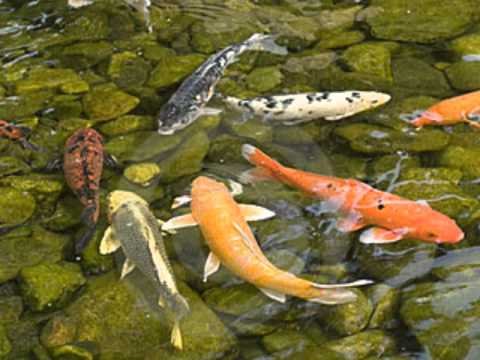

In [29]:
image_num = 2

Image(filename=image_list[image_num-1], width=600)

## Part 3 - AutoML

Use [TPOT](https://github.com/EpistasisLab/tpot) to fit a predictive model for the King County housing data, with `price` as the target output variable.

In [2]:
!pip install tpot

    100% |████████████████████████████████| 901kB 14.6MB/s 
    100% |████████████████████████████████| 942kB 22.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/86/5c/dd/c7673fbaccb901ec1a4eb79017fa5b65766805d2a98f954b9a
  Stored in directory: /root/.cache/pip/wheels/22/ea/bf/dc7c8a2262025a0ab5da9ef02282c198be88902791ca0c6658
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built tpot deap stopit


In [3]:
!wget https://raw.githubusercontent.com/ryanleeallred/datasets/master/kc_house_data.csv

--2019-04-12 15:04:29--  https://raw.githubusercontent.com/ryanleeallred/datasets/master/kc_house_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2515206 (2.4M) [text/plain]
Saving to: ‘kc_house_data.csv’

kc_house_data.csv   100%[===================>]   2.40M  --.-KB/s    in 0.07s   

2019-04-12 15:04:29 (32.4 MB/s) - ‘kc_house_data.csv’ saved [2515206/2515206]



In [4]:
!head kc_house_data.csv

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
"7129300520","20141013T000000",221900,3,1,1180,5650,"1",0,0,3,7,1180,0,1955,0,"98178",47.5112,-122.257,1340,5650
"6414100192","20141209T000000",538000,3,2.25,2570,7242,"2",0,0,3,7,2170,400,1951,1991,"98125",47.721,-122.319,1690,7639
"5631500400","20150225T000000",180000,2,1,770,10000,"1",0,0,3,6,770,0,1933,0,"98028",47.7379,-122.233,2720,8062
"2487200875","20141209T000000",604000,4,3,1960,5000,"1",0,0,5,7,1050,910,1965,0,"98136",47.5208,-122.393,1360,5000
"1954400510","20150218T000000",510000,3,2,1680,8080,"1",0,0,3,8,1680,0,1987,0,"98074",47.6168,-122.045,1800,7503
"7237550310","20140512T000000",1.225e+006,4,4.5,5420,101930,"1",0,0,3,11,3890,1530,2001,0,"98053",47.6561,-122.005,4760,101930
"1321400060","20140627T000000",257500,3,2.25,1715,6819,"2",0,0,3,7,1715,0,1995,0,"98003",47.3097,-122.327,2238,6819
"2

As with previous questions, your goal is to run TPOT and successfully run and report error at the end.  Also, in the interest of time, feel free to choose small `generation=1` and `population_size=10` parameters so your pipeline runs efficiently and you are able to iterate and test.

*Hint* - you'll have to drop and/or type coerce at least a few variables to get things working. It's fine to err on the side of dropping to get things running, as long as you still get a valid model with reasonable predictive power.

In [5]:
from tpot import TPOTRegressor

df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [9]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [8]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [11]:
from sklearn.model_selection import train_test_split

y = df['price'].values

cols_drop = ['id', 'date', 'price']
X = df.drop(cols_drop, axis=1).values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size=0.25)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16209, 18), (5404, 18), (16209,), (5404,))

In [16]:
# TODO - your code!

%%time

tpot = TPOTRegressor(generations=1, population_size=20, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

Generation 1 - Current best internal CV score: -18321475526.941673

Best pipeline: GradientBoostingRegressor(ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=0.4, min_samples_leaf=20, min_samples_split=10, n_estimators=100), alpha=0.75, learning_rate=0.5, loss=ls, max_depth=7, max_features=0.8500000000000001, min_samples_leaf=17, min_samples_split=14, n_estimators=100, subsample=0.7500000000000001)
-18611050256.190258
CPU times: user 5min 53s, sys: 8.56 s, total: 6min 2s
Wall time: 5min 52s


In [17]:
tpot.predict(X_test)

array([838169.07710092, 505118.30049716, 260097.6888601 , ...,
       702433.66493399, 290398.85756146, 461797.02078081])

**Variable Transform**

In [97]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

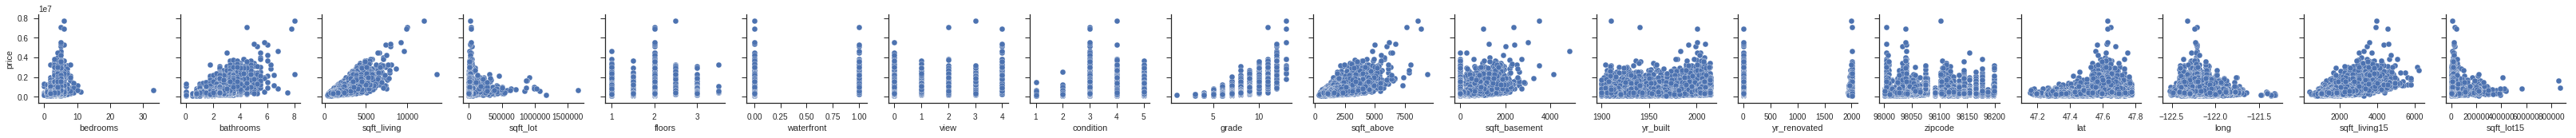

In [98]:
import seaborn as sns

sns.set(style="ticks", color_codes=True)

x_cols = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']


# Only plot the scatterplot of x variables with our y variable
sns.pairplot(data = df, y_vars= 'price', x_vars=x_cols)

**Some variables have nonlinear relationships, one will consider the use of a log transformation of price.**

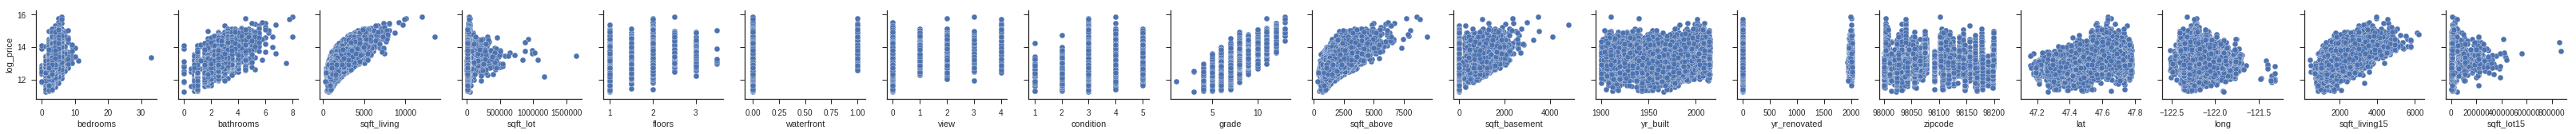

In [100]:
df['log_price'] = np.log(df['price'])

x_cols = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']


# Only plot the scatterplot of x variables with our y variable
sns.pairplot(data = df, y_vars= 'log_price', x_vars=x_cols)

In [101]:
y = df['log_price'].values

cols_drop = ['id', 'date', 'price', 'log_price']
X = df.drop(cols_drop, axis=1).values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size=0.25)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16209, 18), (5404, 18), (16209,), (5404,))

In [102]:
%%time

tpot = TPOTRegressor(generations=1, population_size=20, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

Generation 1 - Current best internal CV score: -0.029849115999273545

Best pipeline: ElasticNetCV(MaxAbsScaler(XGBRegressor(input_matrix, learning_rate=0.1, max_depth=9, min_child_weight=16, n_estimators=100, nthread=1, subsample=0.1)), l1_ratio=0.8, tol=0.1)
-0.03016200729153591
CPU times: user 11min 22s, sys: 31 s, total: 11min 53s
Wall time: 11min 12s


In [103]:
tpot.predict(X_test)

array([12.63932683, 14.55226556, 13.49059143, ..., 12.9198515 ,
       13.6554314 , 13.56436195])

## Part 4 - More...

Answer the following questions, with a target audience of a fellow Data Scientist:

- What do you consider your strongest area, as a Data Scientist?

**I consider my strongest area as a Data Scientist to be my ability to understand complicated data science concepts to the point of having the ability to teach these concepts to others in a simple fashion. This is not a trivial task as some concepts are inherently difficult. **

- What area of Data Science would you most like to learn more about, and why?

**Once I started learning about Recurrent Neural Networks with LSTM, I realized that this is the specific field of Data Science in which I want to focus my career. What makes Neural Networks interesting for me in general is uncovering the mystery of what is "under the hood". Specifically for RNNs, coming from a finance bacground, I am fascinated by asset prediction models and their ability to predict prices. In addition, I am truly fascinated by the ability of an RNN to take a large sample of writing and produce its own writing sample based on this "inspiration". While there are other uses of RNNs, these are the features of RNNs that make me genuinely excited.**


- Where do you think Data Science will be in 5 years?

**Data Science in the next five years will be made simpler and more automated as new packages will allow data scientists to do previous tasks with greater efficiency. This will allow the data scientist to be much more productive prior to the machines taking over. In addition, data scientists will worry less about their local hardware as they will be able to leverage the computing power of big companies like Amazon with AWS and Microsoft with Azure.**

A few sentences per answer is fine - only elaborate if time allows.

Thank you for your hard work, and congratulations! You've learned a lot, and should proudly call yourself a Data Scientist.

**No, thank you!**